## Make a static maps

### Download libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import numpy as np

from matplotlib.colors import Normalize,LogNorm

#######################################################

filename = '../data/cleaned/clean_dataset.csv'

shp_name = '../shapefiles/Belgium-4-Digit-Postcodes-2020.shp'

#results_dir = '../map_visualization_results/'
results_dir = './'

#######################################################

df = pd.read_csv(filename,delimiter=',')

col = 'url'  # Drop the column Url because it needn't for analysis
if col in df.columns:
    df.drop(columns=[col], inplace=True)

## Create cdata for maps

In [2]:
HIGH_VALUE_PROP_PRICE = 500_000
HIGH_VALUE_PROP_PRICE_PER_M2 = 5000

df_count = df.groupby('postal_code').size().reset_index(name='count')

percent_high_price = (
    df.groupby('postal_code')['price']
    .apply(lambda s: 100 * (s > HIGH_VALUE_PROP_PRICE).mean())
    .reset_index(name='percent_high_price')
)

price_variance = df.groupby('postal_code')['price'].var().reset_index(name='price_variance')

mean_area = df.groupby('postal_code')['area'].mean().reset_index(name='mean_area')

if(0):
    print(mean_area.head())
    print(mean_area.describe())
    
if(0):
    print(percent_high_price.head(100))
    pd.set_option('display.float_format', '{:.2f}'.format)
    print( percent_high_price['percent_high_price'].describe() )
    
    percent_high_price['percent_high_price'].plot(kind='hist', bins=100, range=(0, 100), edgecolor='black')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.title('Histogram of Prices')
    plt.show()

######################################################################

df_summary = pd.merge(df_count, percent_high_price, on='postal_code', how='left')
df_summary = df_summary.merge(price_variance, on='postal_code', how='left')
df_summary = df_summary.merge(mean_area, on='postal_code', how='left')



## prepare shapefile, join it with data

In [3]:
gdf = gpd.read_file(shp_name)

gdf['nouveau_PO'] = pd.to_numeric(gdf['nouveau_PO'], errors='coerce').astype('Int64')
df_summary['postal_code'] = pd.to_numeric(df_summary['postal_code'], errors='coerce').astype('Int64')

gdf = gdf.merge(df_summary, left_on='nouveau_PO', right_on='postal_code', how='left')

## Create first map

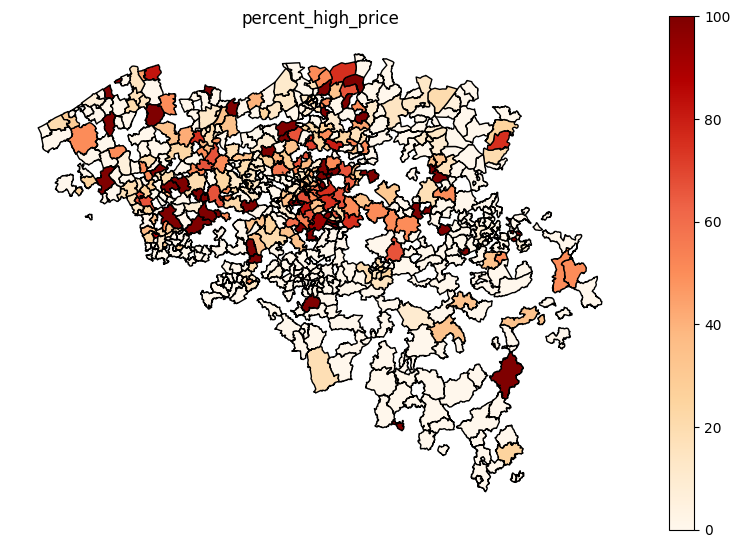

In [4]:
norm = Normalize(vmin=0, vmax=100)

width_px, height_px = 1500, 1000
dpi = 150
figsize = (width_px / dpi, height_px / dpi)
fig, ax = plt.subplots(figsize=figsize)


gdf.plot(
    cmap='OrRd', 
    column='percent_high_price', 
    legend=True,
    norm=norm,
    ax=ax,
    edgecolor='black')

plt.axis('off')
plt.title('percent_high_price')
plt.show

#######################################################

outname = 'map_percent_high_price.png'

filepath = os.path.join(results_dir, outname)

fig.savefig(filepath, dpi=dpi, bbox_inches='tight')

## Create map for variance of price

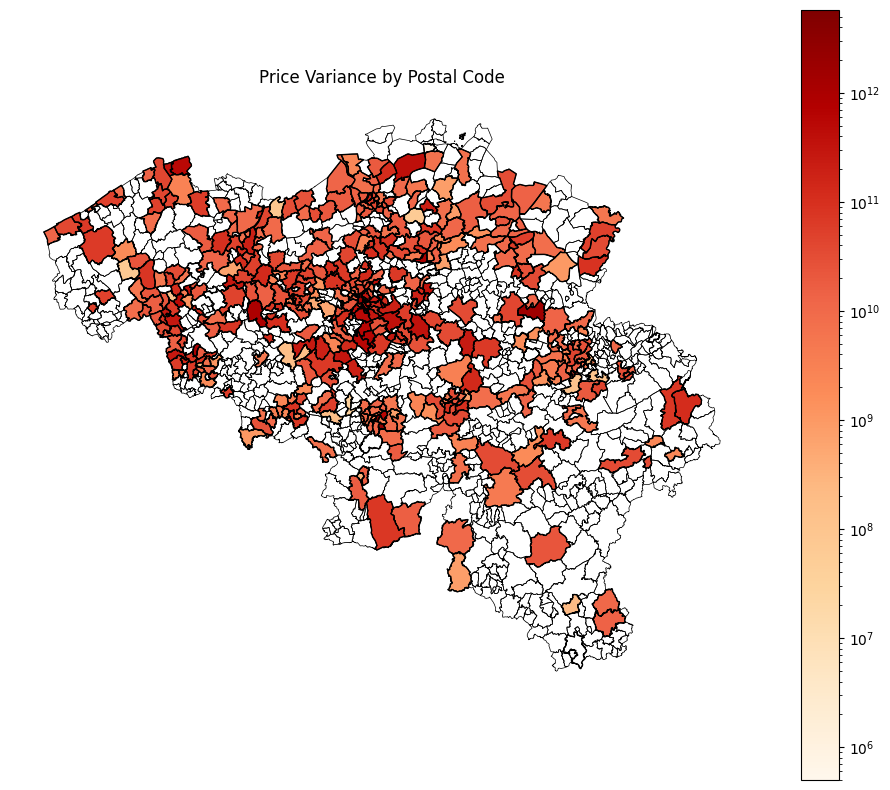

In [5]:
fig, ax = plt.subplots(figsize=(12,10))

norm = LogNorm(vmin=df_summary['price_variance'].replace(0, np.nan).min(),
               vmax=df_summary['price_variance'].max())

gdf.plot(
    column='price_variance',
    cmap='OrRd',
    legend=True,
    norm=norm,
    edgecolor='black',
    ax=ax
)

gdf.boundary.plot(
    color='black',
    linewidth=0.5,
    ax=ax
)

plt.axis('off')
plt.title('Price Variance by Postal Code')
plt.show()


## Mean area

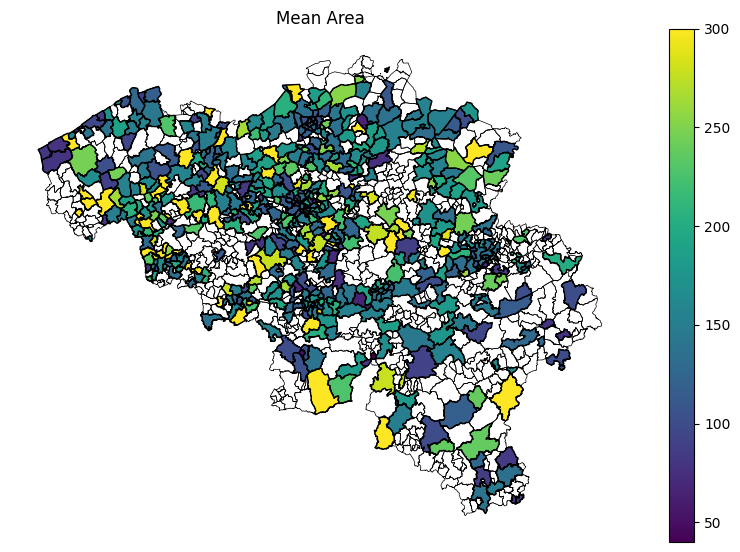

In [6]:
norm = Normalize(vmin=40, vmax=300)

width_px, height_px = 1500, 1000
dpi = 150
figsize = (width_px / dpi, height_px / dpi)
fig, ax = plt.subplots(figsize=figsize)


gdf.plot(
    #cmap='OrRd', 
    column='mean_area', 
    legend=True,
    norm=norm,
    ax=ax,
    edgecolor='black')

gdf.boundary.plot(
    color='black',
    linewidth=0.5,
    ax=ax
)


plt.axis('off')
plt.title('Mean Area')
plt.show

#######################################################

outname = 'map_median_price.png'

filepath = os.path.join(results_dir, outname)

#fig.savefig(filepath, dpi=dpi, bbox_inches='tight')